In [1]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d waalbannyantudre/hate-speech-detection-curated-dataset

 96% 109M/114M [00:02<00:00, 57.1MB/s] 
100% 114M/114M [00:02<00:00, 42.3MB/s]


In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


--2024-01-09 06:34:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-09 06:34:39 (48.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# prompt: unzip and read file

data_dir = '/content/hate-speech-detection-curated-dataset.zip'
unzip_data(data_dir)


In [6]:
df = pd.read_csv('/content/HateSpeechDatasetBalanced.csv')
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [7]:
df.Label.value_counts()

1    364525
0    361594
Name: Label, dtype: int64

In [8]:
# Specify the percentage of data you want to sample (e.g., 10%)
percentage_to_sample = 10

# Use the sample method to get the specified percentage
sampled_df = df.sample(frac=percentage_to_sample / 100)

# Display the sampled DataFrame
sampled_df.shape

(72612, 2)

In [9]:
# prompt: check null values

df.isnull().sum()


Content    0
Label      0
dtype: int64

In [10]:
# prompt: geenrate random sentences to visualize content

import random
for i in range(5):
  print(f"Label: {df.loc[random.randint(0, len(df) - 1)]['Label']}, Content: {df.loc[random.randint(0, len(df) - 1)]['Content']}")


Label: 0, Content: actually i wanted fix clue bot to be a separate edit i forgot that i what a slut in to undo editing template you can argue if it is inappropriate all you want the real issue is that it is spot on and will lead to xenophobic being less of a disruption while he has point of view pushing this has led to him being butt hurt much like you must be in spending so much time posting diffs here and at an i
Label: 0, Content: ritz is german for crack that sounds right if is you mean it as in the german it means cool a k a ritz means crack in english yep that sounds right good job
Label: 1, Content: no discernible skill to give for a visa someone must please contact people from several countries here
Label: 1, Content: issa dome date of passion go natasha dome goal become a professional go player he what a slut born in france half french half senegalese african country at the age of his mother moved to india where he lived for and discovered go in a book written by yuri hot japa

In [11]:
# prompt: create train, test, and val df

train_df = sampled_df.sample(frac=0.7, replace=False)
test_df = sampled_df.loc[~sampled_df.index.isin(train_df.index)]
val_df = test_df.sample(frac=0.5, replace=False)


In [12]:
# prompt: print shape of each df

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Validation data shape: {val_df.shape}")


Train data shape: (50828, 2)
Test data shape: (21784, 2)
Validation data shape: (10892, 2)


In [13]:
train_df['Content']

239890    i took terri to edible in bradenton fla a resi...
159947    i m great hunt you got to see a terrific game ...
551900                     hijab has women it never welcome
635244    absurd people stop you laughing your accusatio...
334093    and not very well like by most of them either ...
                                ...                        
175660    image under mes courts electrifies sub the ima...
158671    i does not agree with that either melissa i am...
96902                   boms and letterboxes the same thing
385773    bias and errors this articles makes it appear ...
551057    that nigga was joe big as shit always fucks me...
Name: Content, Length: 50828, dtype: object

## SPlit data

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["Label"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["Label"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["Label"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [15]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["Label"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["Label"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["Label"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([0, 0, 1, ..., 1, 0, 1])

In [16]:
# prompt: get num of classes and class names

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 2
Class names: [0 1]


## Model 0: Getting a baseline

In [17]:
train_sentences = train_df['Content'].tolist()
val_sentences = val_df['Content'].tolist()
test_sentences = test_df['Content'].tolist()


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Assuming x_train is a list of text documents and y_train is the corresponding labels

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes
text_classifier = Pipeline([
    ('vectorizer', CountVectorizer()),  # Convert text to a bag-of-words representation
    ('classifier', MultinomialNB())      # Use Naive Bayes as the classifier
])

# Fit the model
model_0 = text_classifier.fit(train_sentences, train_labels_encoded)



In [19]:
model_0.score(val_sentences, val_labels_encoded)

0.7858060962174073

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 0, ..., 1, 1, 0])

In [21]:
from helper_functions import calculate_results
baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds
)
baseline_results

{'accuracy': 78.58060962174072,
 'precision': 0.7987228268946993,
 'recall': 0.7858060962174073,
 'f1': 0.7838021835660439}

## Preparing our data for deep sequence models

In [22]:
# How long is each sentence on average?
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

36.135378138034156

In [23]:
# prompt: How long is each sentence on average in train_sentences? Store it in avariable

avg_sentence_length = sum(len(sentence.split()) for sentence in train_sentences) / len(train_sentences)
avg_sentence_length

36.135378138034156

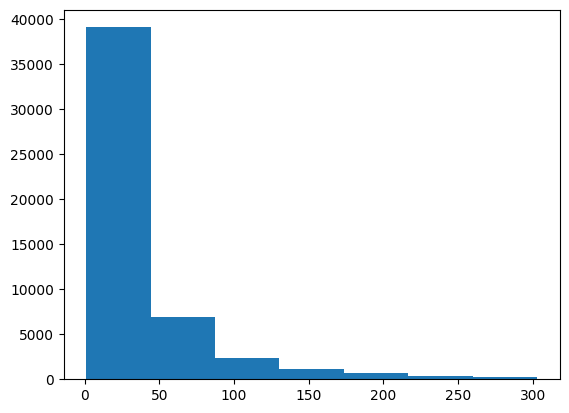

In [24]:

# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [25]:
# prompt: get the long of a sentence that covers 95% of the lengths

output_seq_len  = int(np.percentile(sent_lens, 95))
output_seq_len


128

In [26]:
# prompt:  # How many words are in our vocabulary?

max_tokens = len(model_0.named_steps['vectorizer'].vocabulary_)
max_tokens


50018

In [27]:
# prompt: Create text vectorizer with TextVectorization
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                               output_sequence_length=output_seq_len)
text_vectorizer.adapt(train_sentences)

In [28]:
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/docs/09_SkimLit_nlp_milestone_project_2.ipynb